In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.data
from skimage.color import rgb2gray
from IPython.display import display, update_display, clear_output
import ipywidgets as ipw
from skimage.filters import gaussian, median
from scipy import ndimage as ndi
from skimage.restoration import denoise_nl_means, denoise_wavelet
from skimage.morphology import disk, octagon as oct_func, star, square
from warnings import warn
def horizontal_line(n):
    return np.pad(np.ones((1, 2*n+1)), [[n, n],[0,0]], mode = 'constant', constant_values = 0).astype(int)
def vertical_line(n):
    return horizontal_line(n).T
def cross(n):
    return ((horizontal_line(n)+vertical_line(n))>0).astype(int)
def octagon(n):
    return oct_func(n, n)

In [2]:
def clean_img(x):
    if isinstance(x, tuple):
        x = x[0]
    y = rgb2gray(x)
    if y.dtype==np.uint8:
        y = y/255.0
    if y.dtype==bool:
        y = y/1.0
    return y

sample_images = {c_id: clean_img(getattr(skimage.data, c_id)()) for c_id in ['astronaut',
 'camera',
 'checkerboard',
 'chelsea',
 'clock',
 'coffee',
 'coins',
 'horse',
 'hubble_deep_field',
 'immunohistochemistry',
 'moon',
 'page',
 'text',
 'rocket',
 'stereo_motorcycle']}

def salt_and_pepper(x, strength):
    y = x.copy()
    y[np.random.uniform(0,1, size=x.shape)<strength/2.0] = x.min()
    y[np.random.uniform(0,1, size=x.shape)<strength/2.0] = x.max()
    return y

def additive_gaussian(x, strength):
    return x+np.random.normal(0,strength, size=x.shape)

def multiplicative_gaussian(x, strength):
    return x*np.random.normal(1, strength, size=x.shape)

def horizontally_streaky_salt(x, strength):
    y = x.copy()
    y[np.random.uniform(0,1, size=x.shape[0])<strength/2.0, :] = x.min()
    y[np.random.uniform(0,1, size=x.shape[0])<strength/2.0, :] = x.max()
    return y

def vertically_streaky_salt(x, strength):
    y = x.copy()
    y[:, np.random.uniform(0,1, size=x.shape[1])<strength/2.0] = x.min()
    y[:, np.random.uniform(0,1, size=x.shape[1])<strength/2.0] = x.max()
    return y

def no_filter(x, **kwargs):
    return x

def gaussian_filter(x, size, neighborhood):
    # gaussian from skimage doesn't implement custom neighborhood
    base_kernel = neighborhood(size)
    impulse_img = np.zeros_like(base_kernel, dtype = np.float32)
    impulse_img[impulse_img.shape[0]//2, impulse_img.shape[1]//2] = 1.0
    g_kernel = gaussian(impulse_img, sigma = size)
    g_kernel = g_kernel*base_kernel
    g_kernel /= g_kernel.sum()
    return ndi.convolve(x, g_kernel, mode='constant', cval=0.0)

def median_filter(x, size, neighborhood):
    return median((x*255).clip(0, 255).astype(np.uint8), neighborhood(size))/255.0

def nonlocal_means(x, size, neighborhood):
    if neighborhood.__name__ != 'square':
        warn('Nonlocal means only uses square filters', RuntimeWarning)
    return denoise_nl_means(x, patch_size=size)
def wavelet_filter(x, size, neighborhood):
    if neighborhood.__name__ != 'square':
        warn('Wsvelet means only uses square filters', RuntimeWarning)
    return denoise_wavelet(x, sigma=size)


In [3]:
plt.ioff()
fig, m_axs = plt.subplots(2, 2, figsize = (12, 9), dpi = 120)

def show_results(m_axs, in_img, noise_func, noise_strength, filter_func, filter_args):
    ((ax_img, ax_noise), (ax_filt, ax_diff)) = m_axs
    plot_args = dict(cmap = 'bone', vmin = 0, vmax = 1)
    ax_img.imshow(in_img, **plot_args)
    ax_img.axis('off')
    ax_img.set_title('Original Image')
    
    noise_img = noise_func(in_img, noise_strength)
    
    ax_noise.imshow(noise_img, **plot_args)
    ax_noise.set_title('Noise Image\n%s (%2.1f%%)\nMSE: %2.2f%%' % (noise_func.__name__, 100*noise_strength,
                                                       100*np.mean(np.square(noise_img-in_img))))
    ax_noise.axis('off')
    
    filt_img = filter_func(noise_img, **filter_args)
    
    ax_filt.imshow(filt_img, **plot_args)
    f_args_str = '\n'.join(['{} = {}'.format(k,getattr(v, '__name__', v)) for k,v in filter_args.items()]) if len(filter_args)>0 else ''
    ax_filt.set_title('{}\n{}'.format(filter_func.__name__, f_args_str))
    ax_filt.axis('off')
    
    diff_img = filt_img-in_img
    v_max = np.abs(diff_img).max()
    ax_diff.imshow(diff_img, cmap = 'RdBu', vmin = -v_max, vmax = v_max)
    ax_diff.set_title('Difference Image\nMSE: %2.2f%%' % (100*np.mean(np.square(diff_img))))
    ax_diff.axis('off')

VBox(children=(VBox(children=(HBox(children=(Label(value='Image Name:'), Dropdown(options=('astronaut', 'camera', 'checkerboard', 'chelsea', 'clock', 'coffee', 'coins', 'horse', 'hubble_deep_field', 'immunohistochemistry', 'moon', 'page', 'text', 'rocket', 'stereo_motorcycle'), value='astronaut'))), HBox(children=(Label(value='Noise Type:'), Dropdown(options=(('salt_and_pepper', <function salt_and_pepper at 0x1177b3950>), ('additive_gaussian', <function additive_gaussian at 0x115c45048>), ('multiplicative_gaussian', <function multiplicative_gaussian at 0x118aa0840>), ('vertically_streaky_salt', <function vertically_streaky_salt at 0x118aa07b8>), ('horizontally_streaky_salt', <function horizontally_streaky_salt at 0x118aa0950>)), value=<function salt_and_pepper at 0x1177b3950>))), HBox(children=(Label(value='Noise Level:'), FloatSlider(value=0.1, max=1.0))), HBox(children=(Label(value='Filter Name:'), Dropdown(options=(('no_filter', <function no_filter at 0x118aa09d8>), ('gaussian_filter', <function gaussian_filter at 0x118aa0a60>), ('median_filter', <function median_filter at 0x118aa0ae8>), ('nonlocal_means', <function nonlocal_means at 0x118aa0b70>), ('wavelet_filter', <function wavelet_filter at 0x118aa0bf8>)), value=<function no_filter at 0x118aa09d8>))), HBox(children=(Label(value='Filter Shape:'), Dropdown(options=(('square', <function square at 0x1175a6840>), ('disk', <function disk at 0x1175a69d8>), ('cross', <function cross at 0x1175bcbf8>), ('horizontal_line', <function horizontal_line at 0x1129c2950>), ('vertical_line', <function vertical_line at 0x1175a6620>), ('star', <function star at 0x1175a6d08>), ('octagon', <function octagon at 0x1175bcc80>)), value=<function square at 0x1175a6840>))), HBox(children=(Label(value='Filter Size:'), IntSlider(value=3, max=50, min=1))))),))

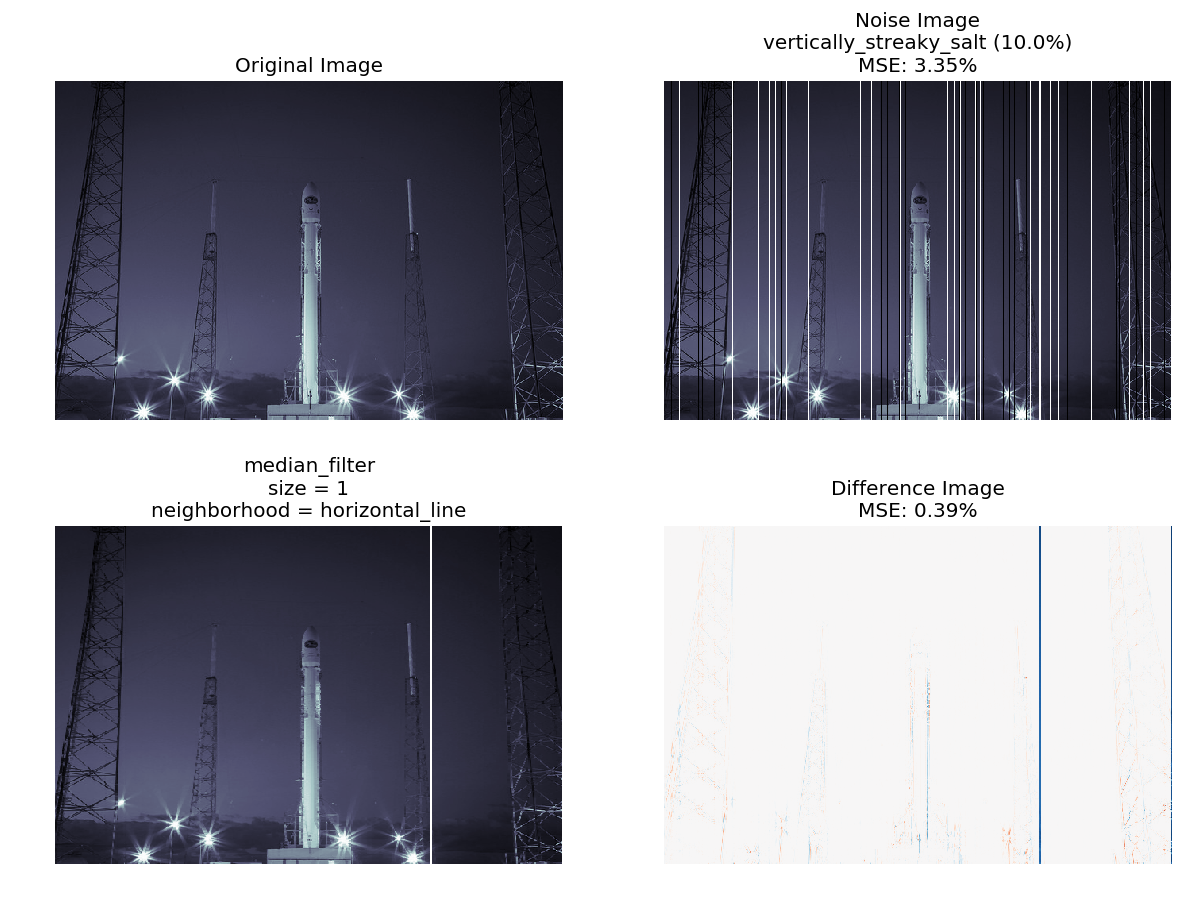

/Users/mader/anaconda/envs/qbi2018/lib/python3.6/site-packages/skimage/restoration/non_local_means.py:108: UserWarning: denoise_nl_means will default to multichannel=False in v0.15
  warn('denoise_nl_means will default to multichannel=False in v0.15')


In [5]:
fn_dict = lambda x: [(getattr(f,'__name__', f), f) for f in x]
image_name = ipw.Dropdown(options = sample_images.keys())
noise_func = ipw.Dropdown(options = fn_dict([salt_and_pepper, additive_gaussian, 
                                                               multiplicative_gaussian, 
                                             vertically_streaky_salt, 
                                             horizontally_streaky_salt]))
noise_level = ipw.FloatSlider(min = 0, max = 1, value = 0.1, step = 0.025)
filter_func = ipw.Dropdown(options = fn_dict([no_filter, gaussian_filter, median_filter, nonlocal_means, wavelet_filter]))

neighbor_functions = [square, disk, cross, horizontal_line, vertical_line, star, octagon]
filter_shape = ipw.Dropdown(options = fn_dict(neighbor_functions))
filter_size = ipw.IntSlider(min =1, max = 50, value = 3)

display(ipw.VBox([ipw.VBox([ipw.HBox([ipw.Label(value = 'Image Name:'), image_name]), 
                    ipw.HBox([ipw.Label(value = 'Noise Type:'), noise_func]),
                    ipw.HBox([ipw.Label(value = 'Noise Level:'), noise_level]),
                    ipw.HBox([ipw.Label(value = 'Filter Name:'), filter_func]),
                    ipw.HBox([ipw.Label(value = 'Filter Shape:'), filter_shape]),
                    ipw.HBox([ipw.Label(value = 'Filter Size:'), filter_size])        
                   ])]))
display(fig, display_id = 'nice_figure') # need to create figure before callbacks

def update_image(*args):
    show_results(m_axs, 
                 sample_images[image_name.value],
                 noise_func.value, 
                 noise_level.value, 
                 filter_func.value, 
                 {'size': filter_size.value,
                  'neighborhood': filter_shape.value
                 })
    update_display(display_id = 'nice_figure', obj = fig)
update_image()    

image_name.observe(update_image, names='value')
noise_func.observe(update_image, names='value')
noise_level.observe(update_image, names='value')
filter_func.observe(update_image, names='value')
filter_shape.observe(update_image, names='value')
filter_size.observe(update_image, names='value')

In [6]:
from IPython.display import FileLink

In [7]:
?FileLink